In [273]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.rcParams['font.sans-serif'] = ['SimHei'] # 使用黑体
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
# 忽略不必要的警告信息
warnings.filterwarnings('ignore')
# 设置pandas，显示所有列
pd.set_option('display.max_columns', None)

In [274]:
# 加载数据集
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('gender_submission.csv')

# 将标签合并到测试集
test = pd.merge(test, sub, on='PassengerId')

# 合并为总数据集
df = pd.concat([train, test], ignore_index=True)

print("合并后的总数据集大小:", df.shape)
df.head()

合并后的总数据集大小: (1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [275]:
print("缺失值:\n", df.isnull().sum())

# 填充Age和Fare的缺失值
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

# 删除Embarked缺失行
df.dropna(subset=['Embarked'], inplace=True)

# 删除Cabin列
df.drop('Cabin', axis=1, inplace=True)

print("\n缺失值处理完成:\n", df.isnull().sum())

缺失值:
 PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

缺失值处理完成:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [276]:
# 删除重复行
initial_rows = len(df)
df.drop_duplicates(inplace=True)
final_rows = len(df)

print(f"删除了 {initial_rows - final_rows} 个重复行。")

删除了 0 个重复行。


In [277]:
# print("删除 PassengerId、Name 和 Ticket 特征")
# print("删除前的列:", df.columns.tolist())

# df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# print("删除后的列:", df.columns.tolist())

In [278]:
# print("对 Sex 和 Embarked 进行数值编码")
# # 对类别特征进行独热编码
# df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# print("编码后的数据集预览:")
# df.head()

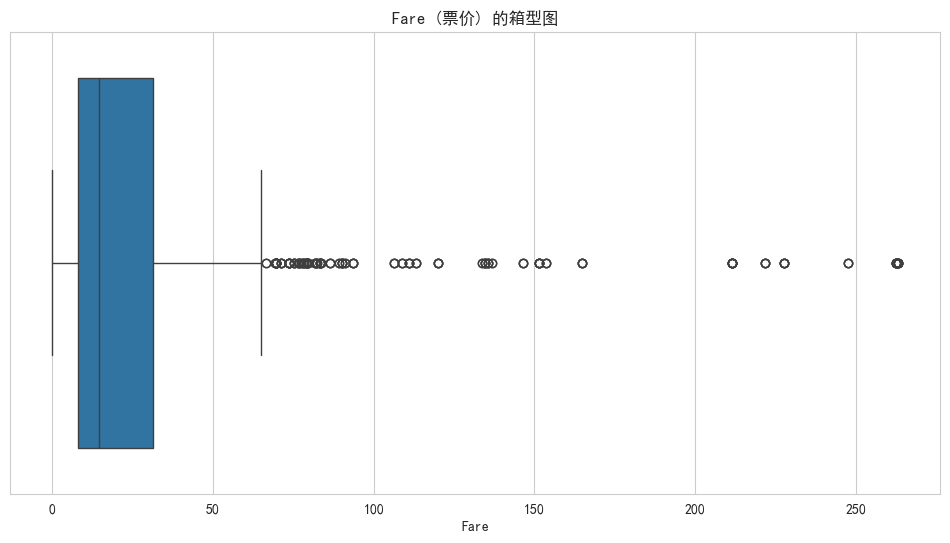

Fare列的平均值为: 33.2096
替换前Fare的最大值为: 512.3292
已将 4 个异常值替换为平均值。
替换后Fare的最大值为: 263.0000


In [279]:
# 可视化替换前的Fare分布
plt.figure(figsize=(12, 6))
sns.boxplot(x=full_df['Fare'])
plt.title('Fare (票价) 的箱型图')
plt.show()

# 计算Fare列的平均值
fare_mean = df['Fare'].mean()
print(f"Fare列的平均值为: {fare_mean:.4f}")
print(f"替换前Fare的最大值为: {df['Fare'].max():.4f}")

# 识别大于300的异常值数量
num_outliers = (df['Fare'] > 300).sum()

# 将这些异常值替换为平均值
df.loc[df['Fare'] > 300, 'Fare'] = fare_mean

print(f"已将 {num_outliers} 个异常值替换为平均值。")
print(f"替换后Fare的最大值为: {df['Fare'].max():.4f}")

In [280]:
# 删除无关列
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# 对类别特征进行独热编码
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

print("预处理最终完成的数据集预览:")
df.head()

预处理最终完成的数据集预览:


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


In [281]:
# 准备数据
X = df.drop('Survived', axis=1)
y = df['Survived']

k_vals = [1, 3, 5, 7, 9]
knn_res = {}

print("\n--- 开始进行KNN模型评估 (10次随机划分) ---")
for k in k_vals:
    accs = []
    for i in range(10):
        # 每次都重新划分并缩放
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 训练和评估
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, pred)
        accs.append(acc)
    
    knn_res[k] = accs
    
    print(f"\nK = {k}:")
    for i, acc in enumerate(accs):
        print(f"  Run {i+1:2d}: {acc:.4f}")
    print(f"  平均准确率: {np.mean(accs):.4f}")


--- 开始进行KNN模型评估 (10次随机划分) ---

K = 1:
  Run  1: 0.7786
  Run  2: 0.7888
  Run  3: 0.7990
  Run  4: 0.8219
  Run  5: 0.7837
  Run  6: 0.7863
  Run  7: 0.8015
  Run  8: 0.7710
  Run  9: 0.7990
  Run 10: 0.7837
  平均准确率: 0.7913

K = 3:
  Run  1: 0.8295
  Run  2: 0.8244
  Run  3: 0.8575
  Run  4: 0.8346
  Run  5: 0.8372
  Run  6: 0.8346
  Run  7: 0.8372
  Run  8: 0.8193
  Run  9: 0.8397
  Run 10: 0.8346
  平均准确率: 0.8349

K = 5:
  Run  1: 0.8626
  Run  2: 0.8372
  Run  3: 0.8702
  Run  4: 0.8372
  Run  5: 0.8448
  Run  6: 0.8346
  Run  7: 0.8346
  Run  8: 0.8295
  Run  9: 0.8575
  Run 10: 0.8626
  平均准确率: 0.8471

K = 7:
  Run  1: 0.8651
  Run  2: 0.8372
  Run  3: 0.8728
  Run  4: 0.8575
  Run  5: 0.8575
  Run  6: 0.8397
  Run  7: 0.8499
  Run  8: 0.8219
  Run  9: 0.8626
  Run 10: 0.8626
  平均准确率: 0.8527

K = 9:
  Run  1: 0.8677
  Run  2: 0.8499
  Run  3: 0.8728
  Run  4: 0.8626
  Run  5: 0.8601
  Run  6: 0.8524
  Run  7: 0.8575
  Run  8: 0.8193
  Run  9: 0.8651
  Run 10: 0.8702
  平均准确率: 0.8578

In [282]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
svm_res = {}

print("\n--- 开始进行SVM模型评估 (10次随机划分) ---")
for kernel in kernels:
    accs = []
    for i in range(10):
        # 每次都重新划分并缩放 (使用与KNN相同的随机种子)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # 训练和评估
        model = SVC(kernel=kernel, gamma='auto', random_state=i) 
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, pred)
        accs.append(acc)
        
    svm_res[kernel] = accs
    
    print(f"\n核函数(Kernel): {kernel}")
    for i, acc in enumerate(accs):
        print(f"  Run {i+1:2d}: {acc:.4f}")
    print(f"  平均准确率: {np.mean(accs):.4f}")


--- 开始进行SVM模型评估 (10次随机划分) ---

核函数(Kernel): linear
  Run  1: 0.8499
  Run  2: 0.8626
  Run  3: 0.8702
  Run  4: 0.8524
  Run  5: 0.8473
  Run  6: 0.8499
  Run  7: 0.8575
  Run  8: 0.8219
  Run  9: 0.8499
  Run 10: 0.8677
  平均准确率: 0.8529

核函数(Kernel): rbf
  Run  1: 0.8626
  Run  2: 0.8575
  Run  3: 0.8804
  Run  4: 0.8651
  Run  5: 0.8626
  Run  6: 0.8626
  Run  7: 0.8626
  Run  8: 0.8372
  Run  9: 0.8601
  Run 10: 0.8804
  平均准确率: 0.8631

核函数(Kernel): poly
  Run  1: 0.8626
  Run  2: 0.8601
  Run  3: 0.8779
  Run  4: 0.8524
  Run  5: 0.8575
  Run  6: 0.8601
  Run  7: 0.8601
  Run  8: 0.8244
  Run  9: 0.8601
  Run 10: 0.8779
  平均准确率: 0.8593

核函数(Kernel): sigmoid
  Run  1: 0.7608
  Run  2: 0.7634
  Run  3: 0.7583
  Run  4: 0.8193
  Run  5: 0.7455
  Run  6: 0.7735
  Run  7: 0.7812
  Run  8: 0.7354
  Run  9: 0.7659
  Run 10: 0.7659
  平均准确率: 0.7669
